--- Eigenvalues and Phases ---
Eigenvalue 0: 0.3209+0.9471j, Phase: 0.198000
Eigenvalue 1: -0.8306-0.5569j, Phase: 0.594000


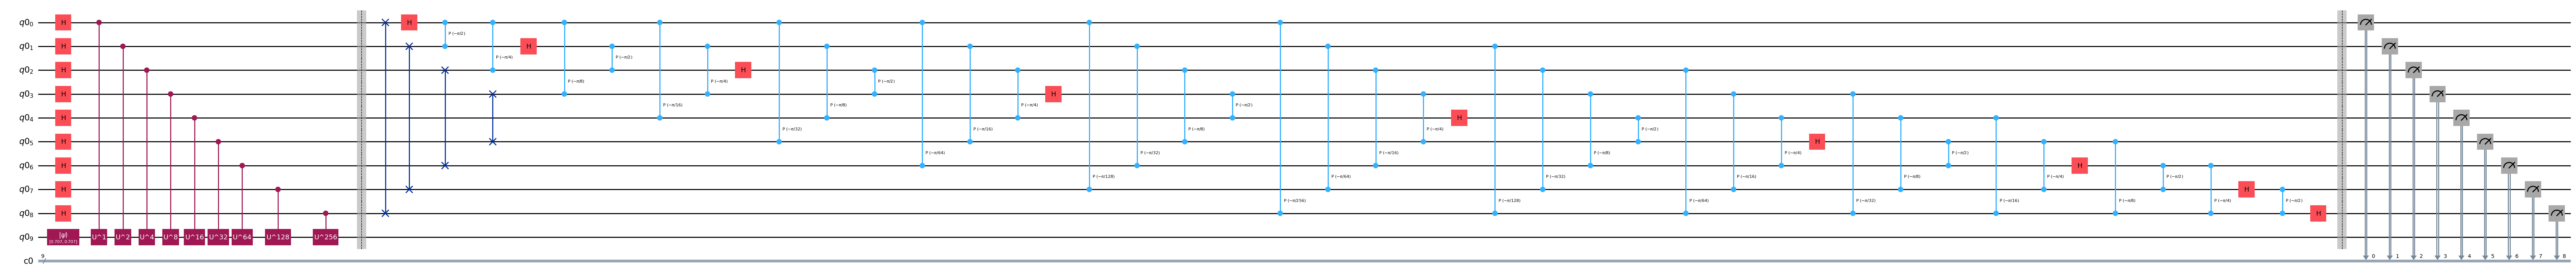

c:\miniconda\envs\qiskit310\lib\site-packages\qiskit\compiler\transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(



[Optimized QPE - eigenstate 0]
qubit number is:  9
Most frequent measurement:  001100101
Estimated phase: 0.197265625
True phase:      0.198000000
Absolute error:  0.000734375
circuit Depth:   29
Total time：2.941044 秒


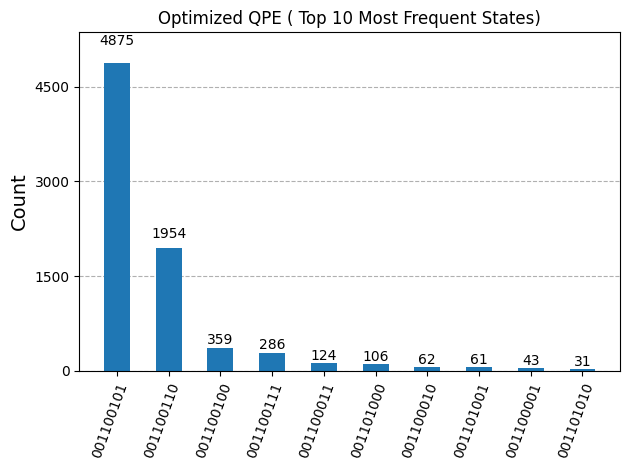

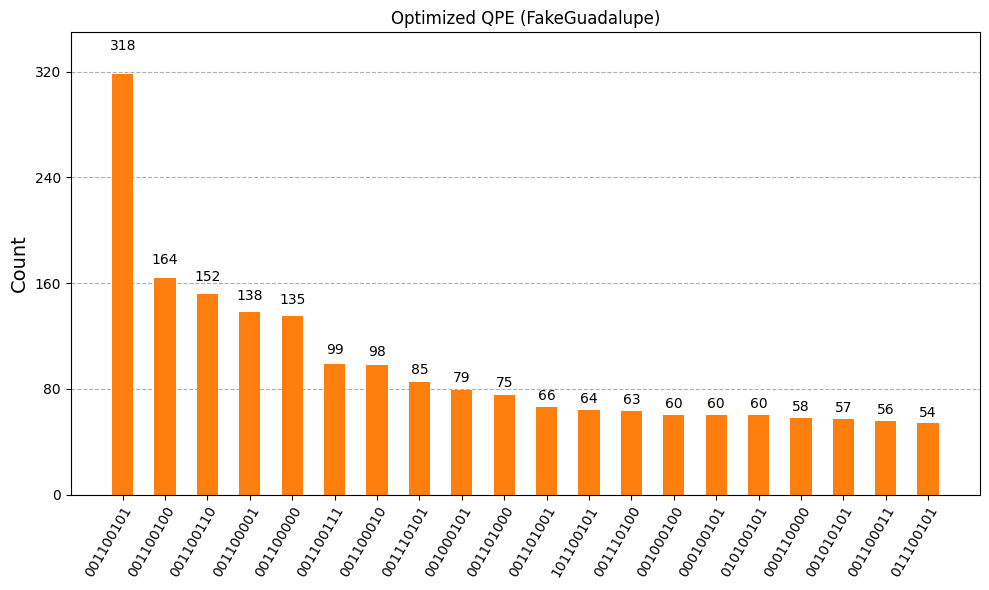

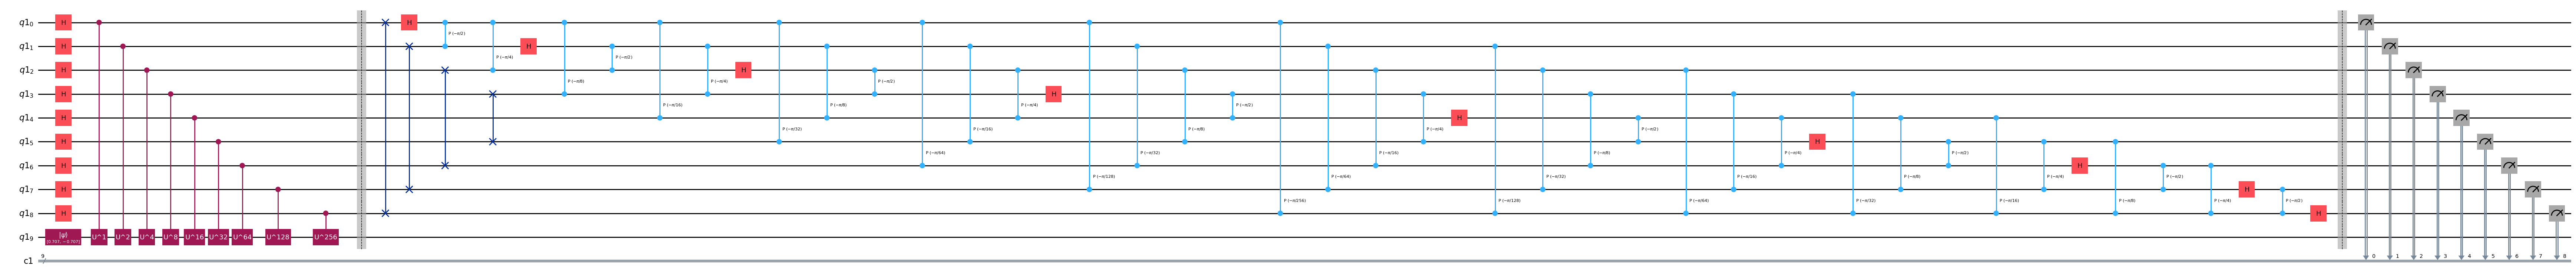

c:\miniconda\envs\qiskit310\lib\site-packages\qiskit\compiler\transpiler.py:269: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pm = generate_preset_pass_manager(



[Optimized QPE - eigenstate 1]
qubit number is:  9
Most frequent measurement:  100110000
Estimated phase: 0.593750000
True phase:      0.594000000
Absolute error:  0.000250000
circuit Depth:   29
Total time：36.615574 秒


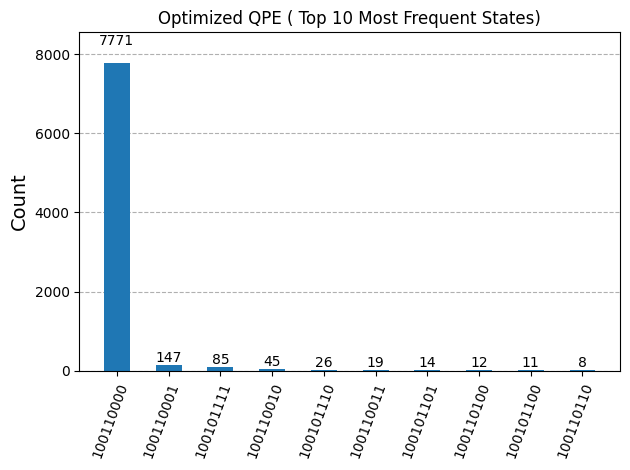

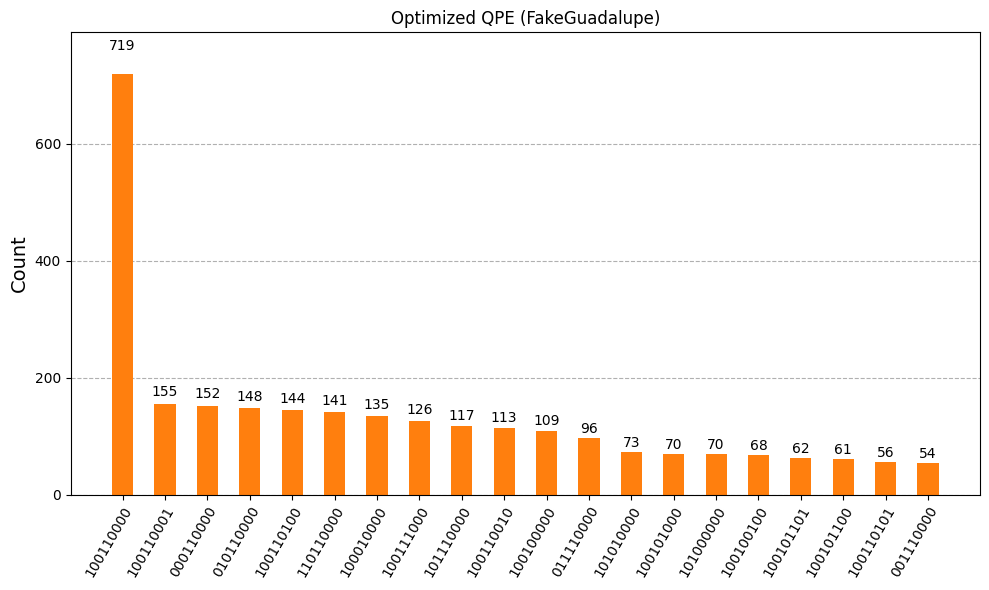

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import pi
import numpy as np
from scipy.linalg import expm
from collections import Counter
from qiskit.quantum_info import Operator
from matplotlib import pyplot as plt
from qiskit.circuit.library import StatePreparation
from qiskit.circuit.library import QFT

import time

from qiskit_ibm_runtime.fake_provider import FakeGuadalupeV2  # or FakeTorontoV2, FakeKolkataV2, FakeMumbaiV2
from qiskit_ibm_runtime.fake_provider import FakeNairobiV2
from qiskit_aer.noise import NoiseModel
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import AerSimulator  
%matplotlib inline


qnum = 9
actual_phase = 0.198
shots = 8192
a = 2  # Toeplitz 矩陣大小

# ===  Hermitian Toeplitz 矩陣 ===
def generate_tridiagonal_toeplitz(n):
    #return np.eye(n)
    A = 2 * np.eye(n)
    for i in range(n - 1):
        A[i, i + 1] = -1
        A[i + 1, i] = -1
    return A
start_time = time.time()
L = generate_tridiagonal_toeplitz(a)    #Hermitian Toeplitz 通道矩陣
U = expm(1j * 2 * pi * actual_phase * L)

# === IQFT ===
def inverse_qft(circ, qubits):
    n = len(qubits)
    for j in range(n // 2):
        circ.swap(qubits[j], qubits[n - j - 1])
    for j in range(n):
        circ.h(qubits[j])
        for k in range(j + 1, n):
            circ.cp(-np.pi / (2 ** (k - j)), qubits[k], qubits[j])
    circ.barrier()


# === LuGo QPE  ===
def run_lugo_qpe(target_state, true_phase, index):
    target_qubits = int(np.log2(U.shape[0]))
    q = QuantumRegister(qnum + target_qubits)
    c = ClassicalRegister(qnum)
    qc = QuantumCircuit(q, c)
    
    # Step 1: H on counting qubits
    for i in range(qnum):
        qc.h(q[i])

    # Step 2: 初始化 eigenstate
    #vec = np.asarray(target_state, dtype=complex).reshape(-1)
    #vec = vec / np.linalg.norm(vec)
    #qc.append(StatePreparation(vec, label=f"|phi_{index}>"), [q[qnum + j] for j in range(target_qubits)])

    qc.initialize(target_state, [q[qnum + j] for j in range(target_qubits)])

    # Step 3: controlled-U^{2^i}
    for i in range(qnum):
        exponent = 2 ** i
        start_gate = time.time()
        U_power = np.linalg.matrix_power(U, exponent)
        sub_qc = QuantumCircuit(target_qubits)
        sub_qc.unitary(Operator(U_power), range(target_qubits))
        controlled_gate = sub_qc.to_gate(label=f"U^{exponent}").control(1)
        end_gate = time.time()
        qc.append(controlled_gate, [q[i]] + [q[qnum + j] for j in range(target_qubits)])
    qc.barrier()

    # Step 4: IQFT
    inverse_qft(qc, q[:qnum])

    # Step 5: 測量
    qc.measure(q[:qnum], c)
    qc.draw('mpl', fold=-1)
    plt.show()

 # ""====== Ideal 模擬 ======
 #   ideal_backend = Aer.get_backend('aer_simulator')
 #    tqc_ideal = transpile(qc, backend=ideal_backend, optimization_level=1)
 #    counts_ideal = ideal_backend.run(tqc_ideal, shots=shots).result().get_counts()
 #    most_ideal = max(counts_ideal, key=counts_ideal.get)
 #    est_ideal = int(most_ideal, 2) / (2 ** qnum)  

    # ====== Noisy 模擬 ======
    fake = FakeGuadalupeV2()
    noise_model  = NoiseModel.from_backend(fake)
    basis_gates  = noise_model.basis_gates
    coupling_map = fake.coupling_map

    noisy_backend = AerSimulator(noise_model=noise_model,
                                 coupling_map=coupling_map,
                                 basis_gates=basis_gates)
    tqc_noisy = transpile(qc, backend=noisy_backend,
                          basis_gates=basis_gates,
                          coupling_map=coupling_map,
                          optimization_level=1)
    result_noisy = noisy_backend.run(tqc_noisy, shots=shots).result()
    counts_noisy = result_noisy.get_counts()
    most_noisy = max(counts_noisy, key=counts_noisy.get)
    est_noisy = int(most_noisy, 2) / (2 ** qnum)


    # 模擬執行
    backend = Aer.get_backend('qasm_simulator')
    job = backend.run(transpile(qc, backend), shots=shots)
    result = job.result()
    counts = result.get_counts()
    most = max(counts, key=counts.get)
    est_phase = int(most, 2) / (2 ** qnum)
    end_time = time.time()
    print(f"\n[Optimized QPE - eigenstate {index}]")
    print('qubit number is: ',qnum)
    print(f'Most frequent measurement: ',most)
    print(f"Estimated phase: {est_phase:.9f}")
    print(f"True phase:      {true_phase:.9f}")
    print(f"Absolute error:  {abs(est_phase - true_phase):.9f}")
    print(f"circuit Depth:   {qc.depth()}")
    print(f"Total time：{end_time - start_time:.6f} 秒")
    plot_histogram(counts, number_to_keep=10,sort='value_desc',bar_labels=True,title=f"Optimized QPE ( Top 10 Most Frequent States)")
    plt.show() 
    total = sum(counts_noisy.values())
    probs_noisy = {k: v/total for k, v in counts_noisy.items()}

    fig = plot_histogram(
        counts_noisy,
        number_to_keep=20,
        sort='value_desc',
        bar_labels=True,
        title=f"Optimized QPE (FakeGuadalupe)",
        figsize=(10,6),
        color='tab:orange' 
    )
    ax = fig.axes[0]
    ax.set_ylabel("Count")
    for t in ax.get_xticklabels():
        t.set_rotation(60); 
        t.set_ha('right')
    plt.tight_layout()
    plt.show()

# === main ===
eigvals, eigvecs = np.linalg.eig(U)
print("--- Eigenvalues and Phases ---")
for i, eigval in enumerate(eigvals):
    phase = np.angle(eigval) / (2 * np.pi)
    if phase < 0:
        phase += 1
    print(f"Eigenvalue {i}: {eigval:.4f}, Phase: {phase:.6f}")

# 對每個特徵態執行 QPE
for i in range(len(eigvals)):
    phase = np.angle(eigvals[i]) / (2 * np.pi)
    if phase < 0:
        phase += 1
    run_lugo_qpe(eigvecs[:, i], phase, i)




